# Who's that Pokémon : Transfer Learning For Pokémon Type Image Classification

By: Nathan Yao <br>
Github: https://github.com/nathanyao13

________________________________________________________________________________________________________________________________________________________________
![Gen 1 Starters](https://imgur.com/uLKRVW7.png)
________________________________________________________________________________________________________________________________________________________________

## Background:

Transfer learning is a technique that leverages a model previously trained on a large dataset and adapts it to a new, related task. It is especially popular in 
image classification, where training a model from scratch would typically require vast amounts of data and computational resources—resources that may not be accessible to individuals like myself.<br>
<br>
In this project, I applied transfer learning using both ResNet18 and ResNet50 architectures to classify Pokémon images. The appeal of ResNet models lies in  their use of Residual Blocks, which are designed to address the challenges that come with training very deep neural networks.<br>
<br>
Rather than learning a direct mapping between the input and output of each layer, residual blocks focus on learning the residual—the change that needs to be applied to the input. This is achieved by adding shortcut (or skip) connections that pass the input directly to deeper layers, allowing gradients to flow more easily during backpropagation. This structure helps mitigate the problem of performance degradation that occurs when network depth increases, even in the absence of overfitting.<br>
<br>
These residual connections enable the training of very deep networks that outperform their shallower counterparts.<br>
<br>

![resblock](https://imgur.com/hBbqqC8.png)

### Tasks and Models<br>

• Image Classification with 18 type classes (All Pokémon Types) <br>
&nbsp;&nbsp;&nbsp;&nbsp;→ ResNet18 and ResNet50<br>

• Image Classification with 3 type classes (Starter Types: Fire, Water, Grass) <br>
&nbsp;&nbsp;&nbsp;&nbsp;→ ResNet18 and ResNet50<br>
<br>

This notebook contains the implementation of the **ResNet18 transfer learning** <br>
model, specifically for classifying Pokémon as one of the three starter types: <br>
**Fire**, **Water**, or **Grass**.<br>
________________________________________________________________________________________________________________________________________________________________

## Imports

In [1]:

import torch
import torchvision
import torch.nn as nn 
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from dataset_class import PokemonImages

In [2]:
import torch.backends.cudnn as cudnn
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os
from tempfile import TemporaryDirectory

cudnn.benchmark = True

________________________________________________________________________________________________________________________________________________________________

## Data Preperation

In [3]:
df = pd.read_csv('pokemon.csv')
df[['english_name','primary_type','image_path']].head(9)

,english_name,primary_type,image_path
0,bulbasaur,grass,pokemon_images/Bulbasaur.jpg
1,ivysaur,grass,pokemon_images/Ivysaur.jpg
2,venusaur,grass,pokemon_images/Venusaur.jpg
3,charmander,fire,pokemon_images/Charmander.jpg
4,charmeleon,fire,pokemon_images/Charmeleon.jpg
5,charizard,fire,pokemon_images/Charizard.jpg
6,squirtle,water,pokemon_images/Squirtle.jpg
7,wartortle,water,pokemon_images/Wartortle.jpg
8,blastoise,water,pokemon_images/Blastoise.jpg


### Classifying a Pokémon's Primary type:

In [4]:
df = df.dropna(subset=['image_path', 'primary_type']) 
df['main_type'] = df['primary_type'].str.strip()  

In [5]:
filt = (df["main_type"] == "grass") | (df["main_type"] == "fire") | (df["main_type"] == "water")
df = df[filt]

In [6]:
type_names = df['main_type'].unique().tolist()
print("Classes:", type_names)

Classes: ['grass', 'fire', 'water']


In [7]:
label_encoder = LabelEncoder()
df['encoded_type'] = label_encoder.fit_transform(df['main_type'])
type_encoded = df['encoded_type'].unique().tolist()
print("Classes (Encoded):", type_encoded)

Classes (Encoded): [1, 0, 2]


In [8]:
num_classes = len(type_encoded)
print("Number of Classes: ", num_classes)

Number of Classes:  3


In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, 
                                    stratify=df['encoded_type'], 
                                    random_state = 13)

### Loading Data

In [10]:
trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [11]:
train_dataset = PokemonImages(df = train_df, label = "encoded_type", transform=trans)
val_dataset = PokemonImages(df = val_df, label = "encoded_type", transform=trans)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


________________________________________________________________________________________________________________________________________________________________

## ResNet18 Architecture

![Resnet archiecture](https://imgur.com/0Zdb0Oq.png)

In [13]:
resnet18 = models.resnet18(weights= models.ResNet18_Weights.DEFAULT)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

________________________________________________________________________________________________________________________________________________________________

## Freezing the CNN 

From the architecture above, we observe that the final layer of the model is a fully connected linear layer.  
This is the layer we want to modify and train for our specific classification task.  

However, the original output dimension of this layer is 1000, which corresponds to the ImageNet dataset.  
Since our task only has 3 classes, we need to adjust this final layer.

To do this, we:

1. Freeze all layers in the pretrained model so that their weights remain unchanged.
2. Replace the final linear layer with a new one that outputs the desired number of classes.

This approach allows us to take advantage of the rich feature representations learned by the pretrained ResNet model,  
while only training a small number of parameters in the final layer.

In [14]:
# Freezes the whole model
for param in resnet18.parameters():
    param.requires_grad = False

# Reseting the Final Layer and param.requires_grad = True by default 
# Final Layer is resnet18.fc 
final_layer_features = resnet18.fc.in_features

# Outputting new number of Classes
resnet18.fc = nn.Linear(final_layer_features, num_classes)

# Cross Entropy Loss for Multiple Classes
criterion = nn.CrossEntropyLoss()

# Optimizing all Parameters in the final linear layer using SGD
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.01, momentum=0.9)

# Decrease Learning Rate by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

________________________________________________________________________________________________________________________________________________________________

## Training

### Training Function

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # training mode
                else:
                    model.eval()   # eval mode

                running_loss = 0.0
                running_corrects = 0

                # iterating through data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients every iteration
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # SGD for backwards
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights based on validation results
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [16]:
final_model = train_model(resnet18, criterion, optimizer,
                         lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0827 Acc: 0.4883
val Loss: 1.0424 Acc: 0.4815

Epoch 1/24
----------
train Loss: 0.6479 Acc: 0.7277
val Loss: 0.7538 Acc: 0.7222

Epoch 2/24
----------
train Loss: 0.4716 Acc: 0.8122
val Loss: 0.5031 Acc: 0.7963

Epoch 3/24
----------
train Loss: 0.3218 Acc: 0.8920
val Loss: 0.4468 Acc: 0.8333

Epoch 4/24
----------
train Loss: 0.4735 Acc: 0.8357
val Loss: 0.6712 Acc: 0.7407

Epoch 5/24
----------
train Loss: 0.2431 Acc: 0.9108
val Loss: 0.5714 Acc: 0.8519

Epoch 6/24
----------
train Loss: 0.2495 Acc: 0.9014
val Loss: 0.4917 Acc: 0.8333

Epoch 7/24
----------
train Loss: 0.1323 Acc: 0.9624
val Loss: 0.4908 Acc: 0.7778

Epoch 8/24
----------
train Loss: 0.1365 Acc: 0.9437
val Loss: 0.5109 Acc: 0.8148

Epoch 9/24
----------
train Loss: 0.1192 Acc: 0.9765
val Loss: 0.5335 Acc: 0.8148

Epoch 10/24
----------
train Loss: 0.1217 Acc: 0.9765
val Loss: 0.5306 Acc: 0.8333

Epoch 11/24
----------
train Loss: 0.1497 Acc: 0.9671
val Loss: 0.5213 Acc: 0.8333

Ep

________________________________________________________________________________________________________________________________________________________________

## Visualizing Results

In [17]:
def visualize_random_samples(model, num_images=6):
    model.eval()
    fig = plt.figure(figsize=(10, 10))

    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    indices = random.sample(range(len(val_dataset)), num_images)

    for i, idx in enumerate(indices):
        img, label = val_dataset[idx]
        label = int(label)

        input_tensor = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = int(torch.argmax(output, dim=1).item())

        img_disp = inv_normalize(img).permute(1, 2, 0).numpy()
        img_disp = np.clip(img_disp, 0, 1)

        true_type = label_encoder.inverse_transform([label])[0]
        pred_type = label_encoder.inverse_transform([pred])[0]

        ax = plt.subplot((num_images + 1) // 2, 2, i + 1)
        ax.axis('off')
        ax.set_title(f'Pred: {pred_type}, True: {true_type}')
        ax.imshow(img_disp)

    plt.tight_layout()
    plt.show()

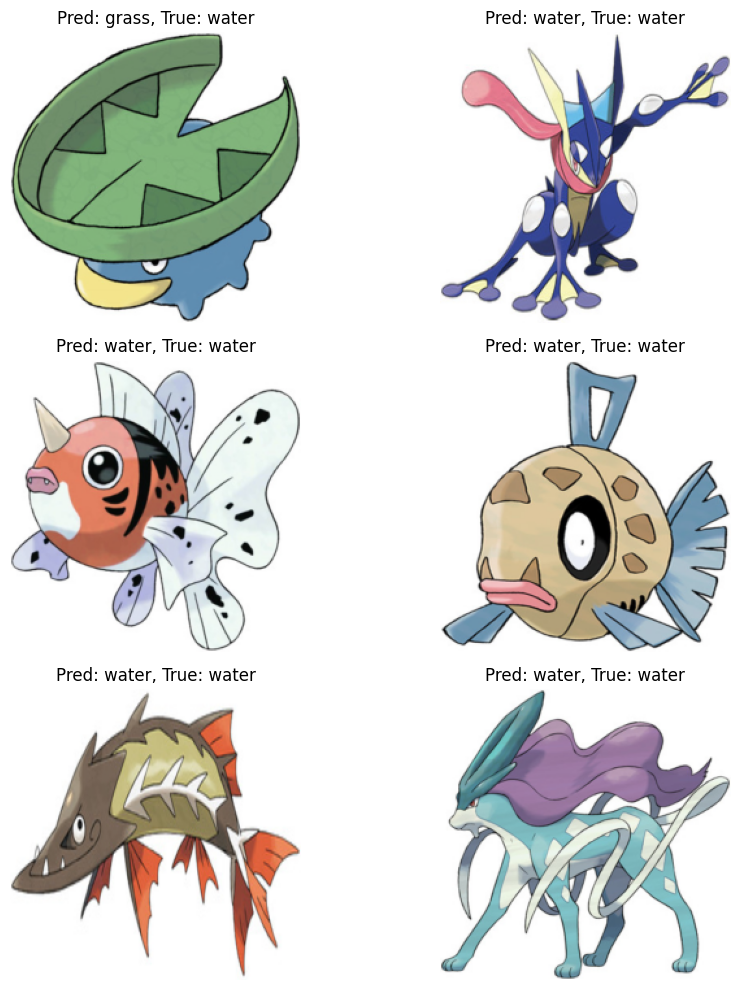

In [18]:
visualize_random_samples(final_model)

________________________________________________________________________________________________________________________________________________________________
## Conclusion

### Results:

**3 Type Classification**:
- ResNet18: 
    - Time to Train: 3m 20s
    - Best Validation Accuracy: 87.03%
- ResNet50:  
    - Time to Train: 11m 28s
    - Best Validation Accuracy: 83.33%

**18 Type Classification**:
- ResNet18:
    - Time to Train: 12m 45s
    - Best Validation Accuracy: 35.00%
- ResNet50: 
    - Time to Train:39m 16s
    - Best Validation Accuracy: 28.88% 

(Note: These results all have standard deviations due to randomness) <br>


**Fine-Tuning Still in Progress.** <br>
**Analysis and Conclusions coming soon...**